In [1]:
from collections import Counter
from datetime import datetime
import math as mt
import sqlite3
import os
import re

from matplotlib import pyplot as plt
import pandas as pd

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-2])
DATA_PATH = f'{ROOT_PATH}/Dataset/DOODLE'

In [3]:
conn   = sqlite3.connect(f'{DATA_PATH}/History')
cursor = conn.cursor()

In [4]:
cursor.execute('select name from sqlite_master where type="table"')
cursor.fetchall()

[('meta',),
 ('downloads',),
 ('downloads_url_chains',),
 ('downloads_slices',),
 ('typed_url_sync_metadata',),
 ('urls',),
 ('sqlite_sequence',),
 ('visits',),
 ('visit_source',),
 ('keyword_search_terms',),
 ('segments',),
 ('segment_usage',),
 ('content_annotations',),
 ('context_annotations',),
 ('clusters',),
 ('clusters_and_visits',),
 ('cluster_keywords',),
 ('cluster_visit_duplicates',)]

In [5]:
query  = 'select * from visits'
visits = pd.read_sql(sql = query, con = conn)
visits.sample(3).T

,7088,9409,147
id,7102,9429,148
url,3695,3461,1722
visit_time,13340091313645897,13340942916951987,13339132561135059
from_visit,7099,0,0
transition,822083584,805306368,805306368
segment_id,20,0,0
visit_duration,3726892,580451037,5438
incremented_omnibox_typed_score,0,0,0
opener_visit,0,9428,147
originator_cache_guid,,,


In [6]:
query = 'select * from urls'
urls  = pd.read_sql(sql = query, con = conn)
urls.sample(3).T

,4086,224,4361
id,4087,225,4362
url,https://cloud.blender.org/p/gallery/57907fb8c3...,http://cafe.naver.com/younggyun,https://mail.naver.com/v2/read/6/15230
title,- Art Gallery — Blender Cloud,"★ 오버워치 공식 한국 커뮤니티 [오공한] ★ 서버,다운로드방법 : 네이버 카페","그러게 말입니다.,"
visit_count,1,0,1
typed_count,0,0,0
last_visit_time,13340189355221567,0,13340265028530877
hidden,0,1,0


In [7]:
visits = visits.rename(columns = {'url' : 'uId'}) 
urls   = urls.rename(columns   = {'id'  : 'uId'})

merge  = pd.merge(visits, urls, how = 'left', on = 'uId')
merge.sample(3).T

,12075,12563,10153
id,12097,12588,10173
uId,3268,5808,4932
visit_time,13341466008115959,13341484570404986,13341026982355290
from_visit,0,0,0
transition,805306368,805306368,805306368
segment_id,0,0,0
visit_duration,47258,247931,2631609
incremented_omnibox_typed_score,0,0,0
opener_visit,12096,12587,10172
originator_cache_guid,,,


In [8]:
## Chrome 베이스 브라우저인 웨일은 1601년 1월 1일 이후 경과한 시간을 마이크로초 단위로 나타냄.
## Unix 시간과 11,644,473,600 초가 차이나 1,000,000으로 나누고, 11,644,473,600을 빼줘야
## 제대로 된 시간이 표시됨.
converted = datetime.fromtimestamp(merge.visit_time[0] / 1_000_000 - 11_644_473_600)
datetime.strftime(converted, '%Y-%m-%d')

'2023-09-14'

In [9]:
chrome2unix           = lambda x: datetime.fromtimestamp(x / 1_000_000 - 11_644_473_600)
merge.visit_time      = merge.visit_time.apply(lambda x: datetime.strftime(chrome2unix(x), '%Y-%m-%d'))
merge.last_visit_time = merge.last_visit_time.apply(lambda x: datetime.strftime(chrome2unix(x), '%Y-%m-%d'))

In [10]:
drop_columns = [
                    'transition', 'segment_id', 'visit_duration',
                    'incremented_omnibox_typed_score', 'opener_visit', 'originator_cache_guid',
                    'originator_visit_id', 'originator_from_visit', 'originator_opener_visit',
                    'is_known_to_sync', 'typed_count', 'hidden'
                ]
merge        = merge.drop(drop_columns, axis = 1)
merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               14510 non-null  int64 
 1   uId              14510 non-null  int64 
 2   visit_time       14510 non-null  object
 3   from_visit       14510 non-null  int64 
 4   url              14510 non-null  object
 5   title            14510 non-null  object
 6   visit_count      14510 non-null  int64 
 7   last_visit_time  14510 non-null  object
dtypes: int64(4), object(4)
memory usage: 907.0+ KB


In [11]:
def preprop4title(title):

    sub_dict = { 
                'stack overflow'    : 'Stack Overflow',
                'at main'           :         'Github',
                'evodmik'           :         'Github',
                'kaggle'            :         'Kaggle',
                'gmail'             :          'Gmail',
                'confirm access'    :         'Github',
                'youtube'           :        'Youtube',
                'dove-nest'         :            'NAS',
                'pull request'      :         'Github',
                'device activation' :         'Github',
                'google'            :         'Google',
                'image library'     :         'Docker',
                'flir'              :         'Github',
                'pyimagesearch'     :  'Pyimagesearch',
                'misc'              :           'Misc',
                'code-server'       :    'Code Server',
                'confluence'        :     'Confluence',
                'laion'             :          'LAION',
                'lucidrains'        :         'Github',
                'showlab'           :         'Github',
                '네이버'              :          'Naver',
                'jupyterlab'        :     'JupyterLab',
                '나무위키'            :       'NamuWiki',
                'wiseodd/'          :         'Github',
                
               } 

    for key in sub_dict.keys():
        if key in title.lower():
            title = title.replace(title, sub_dict[key])
            return title

    return sub_dict['misc']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'JupyterLab'),
  Text(1, 0, 'Google'),
  Text(2, 0, 'Misc'),
  Text(3, 0, 'LAION'),
  Text(4, 0, 'Github'),
  Text(5, 0, 'Kaggle'),
  Text(6, 0, 'Naver'),
  Text(7, 0, 'Confluence'),
  Text(8, 0, 'Gmail'),
  Text(9, 0, 'NamuWiki'),
  Text(10, 0, 'Code Server'),
  Text(11, 0, 'Stack Overflow'),
  Text(12, 0, 'Youtube'),
  Text(13, 0, 'NAS'),
  Text(14, 0, 'Pyimagesearch'),
  Text(15, 0, 'Docker')])

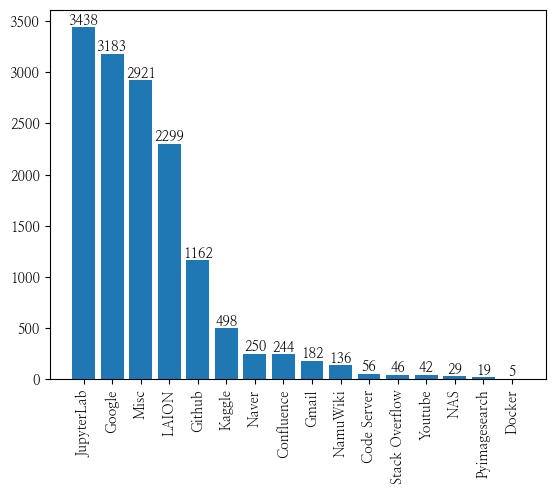

In [12]:
merge_cp       = merge.copy()
merge_cp.title = merge_cp.title.apply(lambda x : preprop4title(x))
title_cnt      = dict(merge_cp.title.value_counts())

plt.bar(title_cnt.keys(), title_cnt.values())
for k, v in title_cnt.items():

    plt.text(k, v, v,
             ha = 'center', va = 'bottom')

plt.xticks(rotation = 90)

In [13]:
def show_text_in_graph (plot, dates, counts, lb = 'visit'): 
    for date, cnt in zip(dates, counts): 
        
        plot.text(date, cnt + 50 if lb == 'visit' else cnt, cnt, ha = 'center', va = 'bottom')


def get_dates_n_counts(column):

    date_n_cnt = dict(merge_cp[column].value_counts())
    date_n_cnt = sorted(date_n_cnt.items(), key = lambda x: x[0])

    dates  = [data[0] for data in date_n_cnt]
    counts = [data[1] for data in date_n_cnt]

    return dates, counts

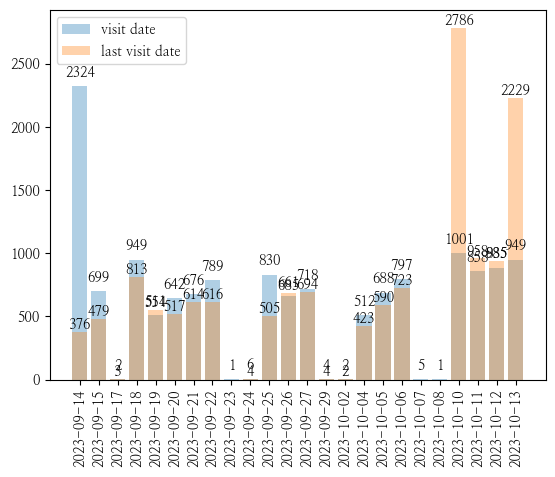

In [14]:
dates     , counts      = get_dates_n_counts(     'visit_time')
last_dates, last_counts = get_dates_n_counts('last_visit_time') 

plt.bar(dates     ,      counts, alpha = 0.35, label =      'visit date')
plt.bar(last_dates, last_counts, alpha = 0.35, label = 'last visit date')

show_text_in_graph(plt, dates, counts)
show_text_in_graph(plt, last_dates, last_counts, lb = 'last')
plt.xticks(rotation = 90)
plt.legend()